# Exercise 2

In [1]:
import numpy as np
import tqdm
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

2022-05-09 18:40:46.011331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 18:40:46.011381: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def read_vocabulary_from_file (filename):
    with open(filename , 'r', encoding ="ISO−8859−1") as f:
        content = f. readlines () # content is a list of lines
        content = [x.strip() for x in content] # removing newline chars
        content = [x for x in content if x != '' and x[0] != ';' and x[-1] != '+']
        return content

In [3]:
positive_words = read_vocabulary_from_file('Data/positive-words.txt')
negative_words = read_vocabulary_from_file('Data/negative-words.txt')

**Compare with given lenght of exercise**

In [4]:
assert len(positive_words) == 2005
assert len(negative_words) == 4783

# Load Embeddings

In [5]:
def load_glove_embeddings (path):
    embeddings = {}
    with open(path , 'r', encoding ='utf−8') as f:
        for line in f:
            values = line.strip ().split ()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings [w] = vectors
        return embeddings

word_dict = load_glove_embeddings('Data/glove.6B.100d.txt')
def get_glove_embedding(query):
    # off−line dictionary
    word = query
    if word not in word_dict.keys():
        return None
    return word_dict[word] # if word is in word_dict


In [6]:
import requests
import json
def get_online_embeddings(query):
     # online query
    response = requests.get(f'https://icoservices.kube.isc.heia-fr.ch/word-embedding/wordvector/word2vec/en/{query}')
    vector = response.json()
    return vector

In [7]:
def prepare_strings_as_vectors(words, embedding_func = get_glove_embedding):
    response = []
    for i, word in tqdm.tqdm(enumerate(words)):
        
        embedding = embedding_func(words[i])
        if embedding is not None:
            response.append((word,embedding))
    return response

In [8]:
from sklearn.utils import shuffle
pos_word_train = positive_words[:1500]
neg_word_train = negative_words[:1500]
pos_word_val = positive_words[1500:]
neg_word_val = negative_words[1500:]

pos_words_emb_train = np.array(prepare_strings_as_vectors(pos_word_train), dtype=object)
neg_words_emb_train = np.array(prepare_strings_as_vectors(neg_word_train), dtype=object)

pos_words_emb_val = np.array(prepare_strings_as_vectors(pos_word_val), dtype=object)
neg_words_emb_val = np.array(prepare_strings_as_vectors(neg_word_train), dtype=object)

1500it [00:00, 314337.05it/s]
1500it [00:00, 353194.63it/s]
505it [00:00, 221769.82it/s]
1500it [00:00, 218818.03it/s]


In [14]:
def get_response(words, default_response):
    return np.full((len(words), 2), default_response)

Y_positive_train = get_response(pos_words_emb_train, np.array([1,0]))
Y_negative_train = get_response(neg_words_emb_train, np.array([0,1]))
Y_positive_val = get_response(pos_words_emb_val, np.array([1,0]))
Y_negative_val = get_response(neg_words_emb_val, np.array([0,1]))

In [18]:
X_train = np.concatenate((pos_words_emb_train[:, 1], neg_words_emb_train[:, 1]))
X_val = np.concatenate((pos_words_emb_val[:, 1], neg_words_emb_val[:, 1]))
Y_train = np.concatenate((Y_positive_train, Y_negative_train))
Y_val = np.concatenate((Y_positive_val, Y_negative_val))

X_train = np.stack(X_train, axis=0)
X_val = np.stack(X_val, axis=0)
Y_train = np.stack(Y_train, axis=0)
Y_val = np.stack(Y_val, axis=0)

In [19]:
print(len(X_train))
print(len(X_val))

2755
1826


In [20]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(2755, 100)
(2755, 2)
(1826, 100)
(1826, 2)


In [21]:
from tensorflow.keras.layers import Dense, Dropout, Activation
def get_model():
    n_embeddings = X_train.shape[1]
    n_hidden = 50
    n_categories = 2
    model = keras.Sequential()
    model.add(Dense(n_embeddings, input_shape=(n_embeddings,), activation='relu'))
    model.add(Dense(n_categories, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.0002)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model
model = get_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 10,302
Trainable params: 10,302
Non-trainable params: 0
_________________________________________________________________


2022-05-09 18:43:28.763274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-09 18:43:28.763317: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-09 18:43:28.763338: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f05db13702d5): /proc/driver/nvidia/version does not exist
2022-05-09 18:43:28.763539: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
log = model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=True, validation_data=(X_val, Y_val))

Epoch 1/15
87/87 [==============================] - 1s 4ms/step - loss: 0.6195 - accuracy: 0.6592 - val_loss: 0.5362 - val_accuracy: 0.7815
Epoch 2/15
87/87 [==============================] - 0s 2ms/step - loss: 0.4649 - accuracy: 0.8319 - val_loss: 0.4192 - val_accuracy: 0.8697
Epoch 3/15
87/87 [==============================] - 0s 2ms/step - loss: 0.3742 - accuracy: 0.8748 - val_loss: 0.3440 - val_accuracy: 0.8855
Epoch 4/15
87/87 [==============================] - 0s 2ms/step - loss: 0.3186 - accuracy: 0.8871 - val_loss: 0.2995 - val_accuracy: 0.8970
Epoch 5/15
87/87 [==============================] - 0s 2ms/step - loss: 0.2828 - accuracy: 0.8947 - val_loss: 0.2784 - val_accuracy: 0.8998
Epoch 6/15
87/87 [==============================] - 0s 2ms/step - loss: 0.2596 - accuracy: 0.9020 - val_loss: 0.2615 - val_accuracy: 0.9036
Epoch 7/15
87/87 [==============================] - 0s 2ms/step - loss: 0.2431 - accuracy: 0.9089 - val_loss: 0.2435 - val_accuracy: 0.9080
Epoch 8/15
87/87 [==

In [23]:
# Add plotting function
def plot_loss_acc(log):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(log.history['loss'], label='Training loss')
    ax1.plot(log.history['val_loss'], label='Val loss')
    ax1.legend()
    ax1.grid()
    ax2.plot(log.history['accuracy'], label='Training acc')
    ax2.plot(log.history['val_accuracy'], label='Val acc')
    ax2.legend()
    ax2.grid()

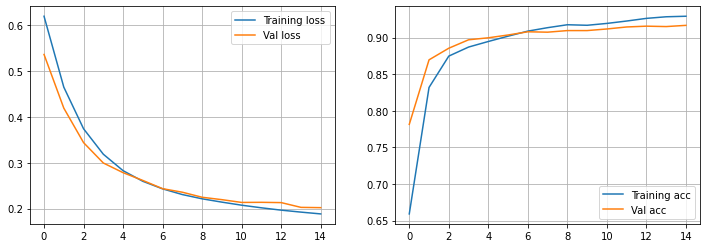

In [24]:
plot_loss_acc(log)

With all of my experiments, I had 

**Looks like the test accuracy is better than it should be according to the exercise!**

In [ ]:
X_test = np.concatenate((X_test_pos_words, X_test_neg_words))

X_test_emb = np.stack(X_test[:,1], axis=0)
Y_test = np.concatenate((y_test_pos, y_test_neg))


result = model(X_test_emb)
pos = np.argpartition(result[:, 0].numpy(), -10)[-10:]
negs = np.argpartition(result[:, 1].numpy(), -10)[-10:]
print('**Words on unseen data**')
print('most positive words:')
print(X_test[pos][:,0])
print('most negative words:')
print(X_test[negs][:,0])

NameError: name 'X_test_pos_words' is not defined

In [26]:
print('uncertein words')
print(', '.join(X_test[(0.6>result[:, 0]) & (result[:, 0]>0.4)][:,0]))

uncertein words


NameError: name 'X_test' is not defined

In [ ]:
›